---

**Proyecto Final de IA:** Monitoreo y Entrenamiento de Inteligencia Artificial para la Predicción de Enfermedad "Parkinson" en Pacientes.

**Autores:**
* Jose Torreglosa
* Jennifer Roa
* Lauren Gonzales

**Institución:** Universidad del Magdalena - Santa Marta - Colombia
<br>**Fecha:** Noviembre 2024

---

En el siguiente documento podremos visualizar una investigacion realizada por una universidad de alto prestigio(OXFORD) dicha investigacion costaba de grabaciones de señales en este caso voz por paciente para determinar cuales eran los pacientes que padecian de la enfermedad y cuales no.
Empezamos importando librerias.

In [104]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from pandas.plotting import scatter_matrix

# Configuraciones adicionales
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## 1. Carga y Preparación de Datos

Definimos una función para importar el conjunto de datos (`parkinsons.data`). Usar una función nos permite cargar los datos de forma dinámica y mantener el código de carga aislado y reutilizable.

In [105]:
def importdata():
    folder = Path.cwd().parent.joinpath('data')
    file = folder.joinpath('parkinsons.data')
    data = pd.read_csv(file,delimiter=',') 
    pd.set_option('display.max_columns', None)
    return data
data = importdata()

## 2. Inspección Inicial del Conjunto de Datos

Realizamos una verificación básica para entender la estructura de nuestros datos.
1.  `.info()`: Nos muestra los tipos de datos de cada columna (Dtype) y si hay valores nulos (Non-Null Count).
2.  `.duplicated().sum()`: Confirma si existen filas duplicadas en el dataset.

**Observaciones:**
* Tenemos 195 registros y 24 columnas.
* No hay valores nulos.
* No hay registros duplicados.
* La columna 'status' es nuestro objetivo (target) y es de tipo `int64`.
* La columna 'name' es un identificador (object) y deberá ser excluida del modelado.

In [106]:
data.info()
print(f"\nTotal de duplicados: {data.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

## 3. Análisis Exploratorio de Datos (EDA)

En esta fase, exploramos los datos para encontrar patrones, identificar problemas (como el desbalanceo) y entender las relaciones entre las variables.

### 3.1. Distribución de Variables Numéricas

Visualizamos las distribuciones de algunas de las características principales usando histogramas. Esto nos ayuda a entender la forma y el rango de cada variable.

<Figure size 1000x500 with 0 Axes>

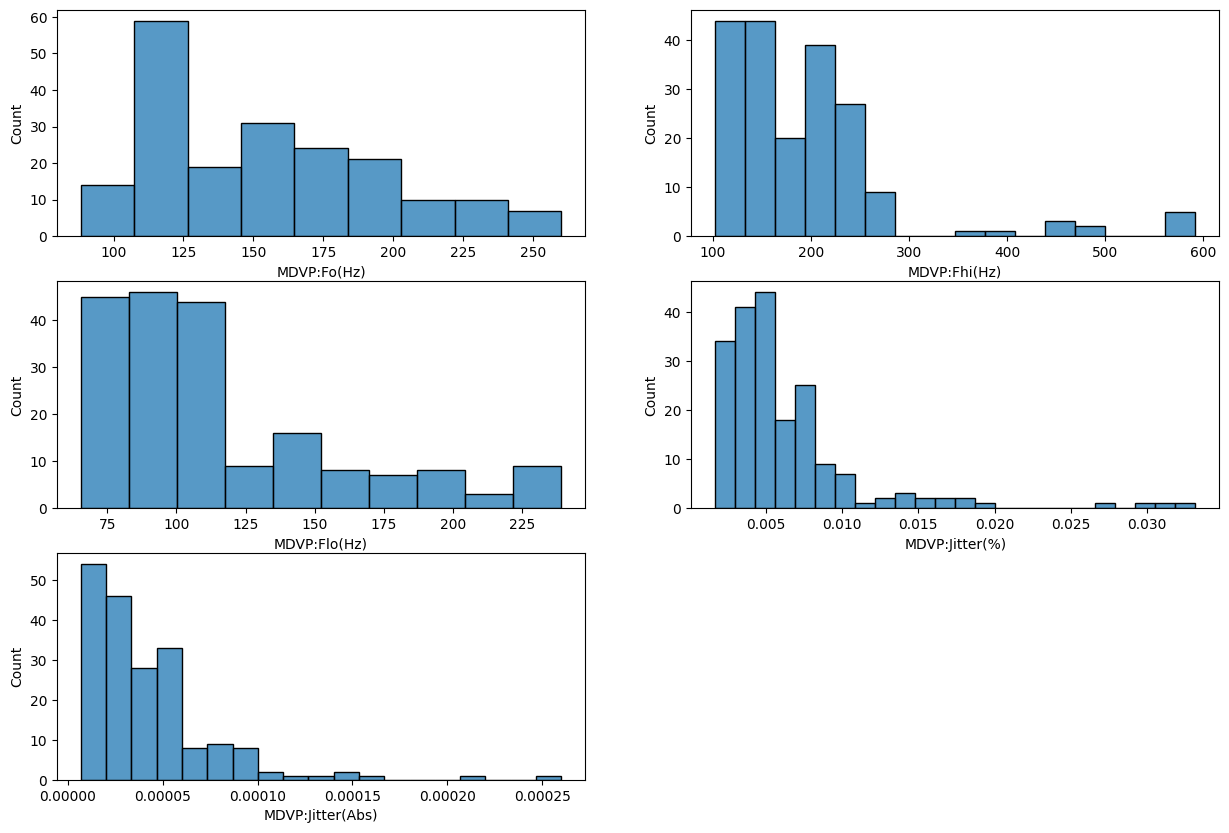

<Figure size 1000x500 with 0 Axes>

In [107]:
i = 1
plt.figure(figsize=(15, 10))
for col in data.iloc[:, 1:6].columns:
    plt.subplot(3, 2, i)
    sns.histplot(data[col])
    i = i + 1

plt.figure(figsize=(10, 5))

### 3.2. Análisis de la Variable Objetivo (Status)

Analizamos la columna `status`, que es la variable que queremos predecir (0 = Sano, 1 = Parkinson).

El conteo de valores (`value_counts`) es crucial, ya que revela el **desbalance de clases** en nuestro dataset:

* **Clase 1 (Parkinson):** 147 muestras
* **Clase 0 (Sano):** 48 muestras

Este desbalance (aprox. 3:1) debe ser solucionado antes de entrenar el modelo (usando técnicas como SMOTE) para evitar que el modelo se incline a predecir siempre la clase mayoritaria.

In [108]:
data.sort_values(by="status", ascending=False)
pd.set_option('display.max_columns', None)
print(data["status"])
data["status"].value_counts()

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64


status
1    147
0     48
Name: count, dtype: int64

### 3.3. Matriz de Correlación General

Generamos un mapa de calor (heatmap) de la correlación entre todas las variables numéricas.

El objetivo es obtener una visión rápida de qué variables están fuertemente relacionadas entre sí (correlación alta, cercana a 1 o -1). Una alta correlación entre características (multicolinealidad) puede ser problemática para algunos modelos de regresión.

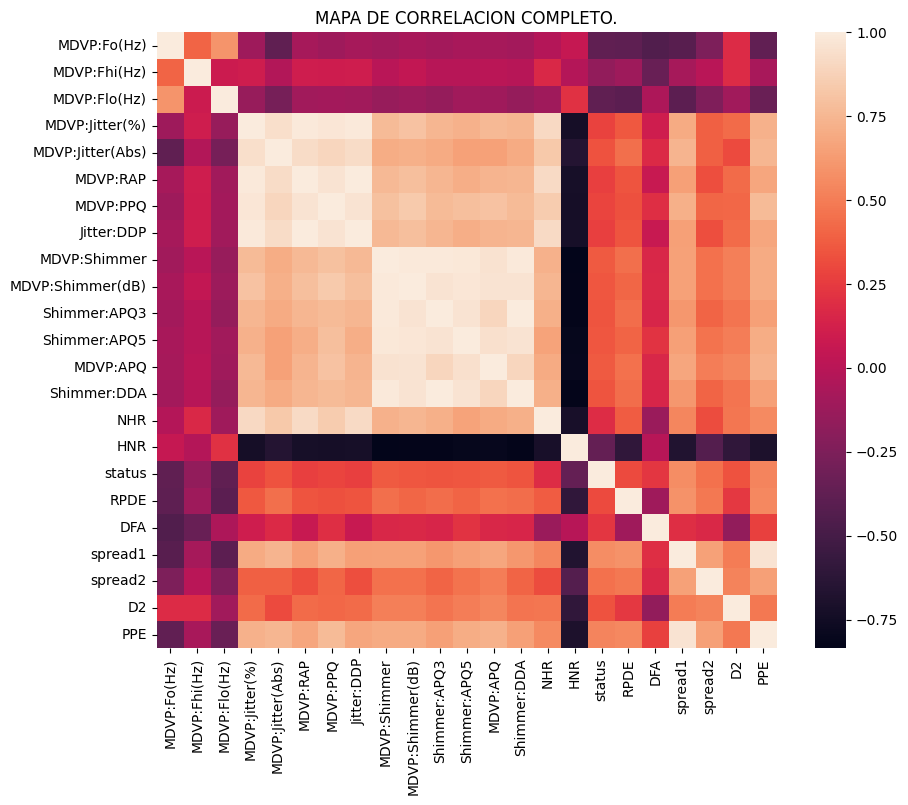

In [109]:
# Discriminacion de float a int.
numeric_data = data.select_dtypes(include=[float, int])
# CORRELACION 
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=False)
plt.title("MAPA DE CORRELACION COMPLETO.")
plt.show()

### 3.4. Detección Específica de Multicolinealidad

Usamos una función para identificar y agrupar programáticamente aquellas características que tienen una correlación extremadamente alta (superior a 0.95).

**Observaciones:**
* Vemos grupos de variables muy correlacionadas (ej. `Shimmer:APQ3` y `Shimmer:DDA`; `MDVP:RAP` y `Jitter:DDP`).
* Esto confirma la necesidad de usar técnicas de **Selección de Características** (como Lasso L1) que puedan manejar esta redundancia, seleccionando solo una variable de cada grupo correlacionado.

In [110]:
# Detección de características correlacionadas
def corr_feature_detect(data, threshold=0.95):
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack()  # valor absoluto de coeficiente de correlación
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1]  # excluir la diagonal
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
            # encontrar todas las características correlacionadas con una sola característica
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            # agregar el bloque de características a la lista
            correlated_groups.append(correlated_block)
    return correlated_groups

# Excluir las columnas no numéricas o de clase para el análisis de correlación
data_for_corr = data.drop(columns=['name', 'status'])

# Ejecutar la función para detectar características correlacionadas
correlated_features = corr_feature_detect(data=data_for_corr, threshold=0.95)

# Imprimir los grupos de características correlacionadas
for group in correlated_features:
    print(group, '\\n')


        feature1          feature2      corr
0   Shimmer:APQ3       Shimmer:DDA  1.000000
11  Shimmer:APQ3      MDVP:Shimmer  0.987625
22  Shimmer:APQ3  MDVP:Shimmer(dB)  0.963198
31  Shimmer:APQ3      Shimmer:APQ5  0.960070 \n
    feature1        feature2      corr
2   MDVP:RAP      Jitter:DDP  1.000000
6   MDVP:RAP  MDVP:Jitter(%)  0.990276
34  MDVP:RAP        MDVP:PPQ  0.957317 \n
   feature1 feature2      corr
24  spread1      PPE  0.962435 \n
    feature1          feature2      corr
26  MDVP:APQ  MDVP:Shimmer(dB)  0.960977
36  MDVP:APQ      MDVP:Shimmer  0.950083 \n


### 3.5. Gráficos de Dispersión (Scatter Matrix)

Generamos matrices de dispersión para visualizar la relación entre pares de variables seleccionadas. Esto nos permite confirmar visualmente las correlaciones identificadas en el heatmap.

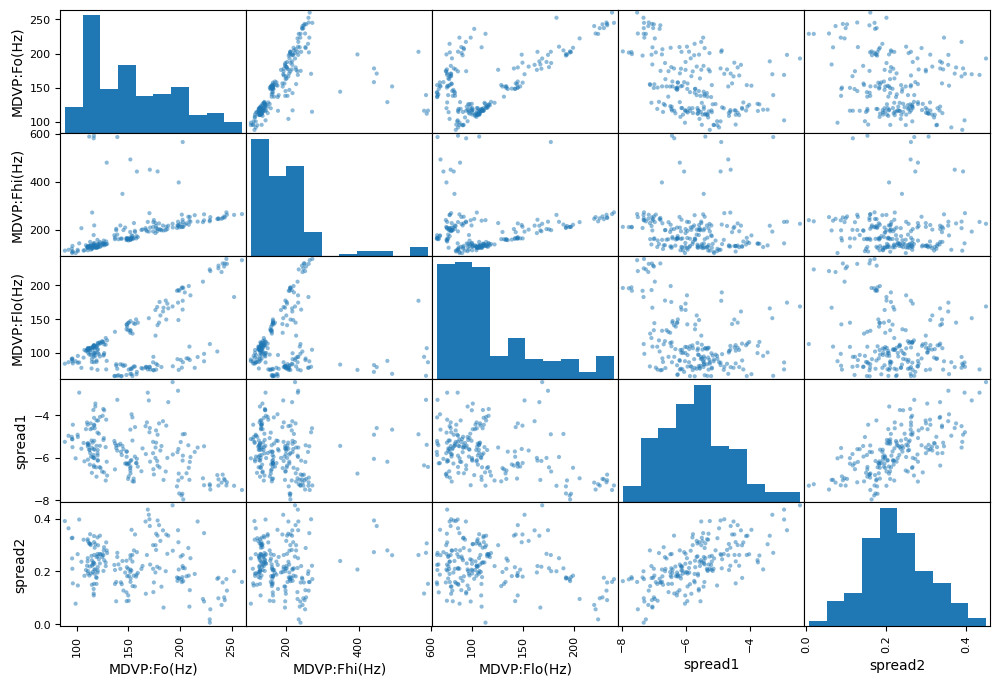

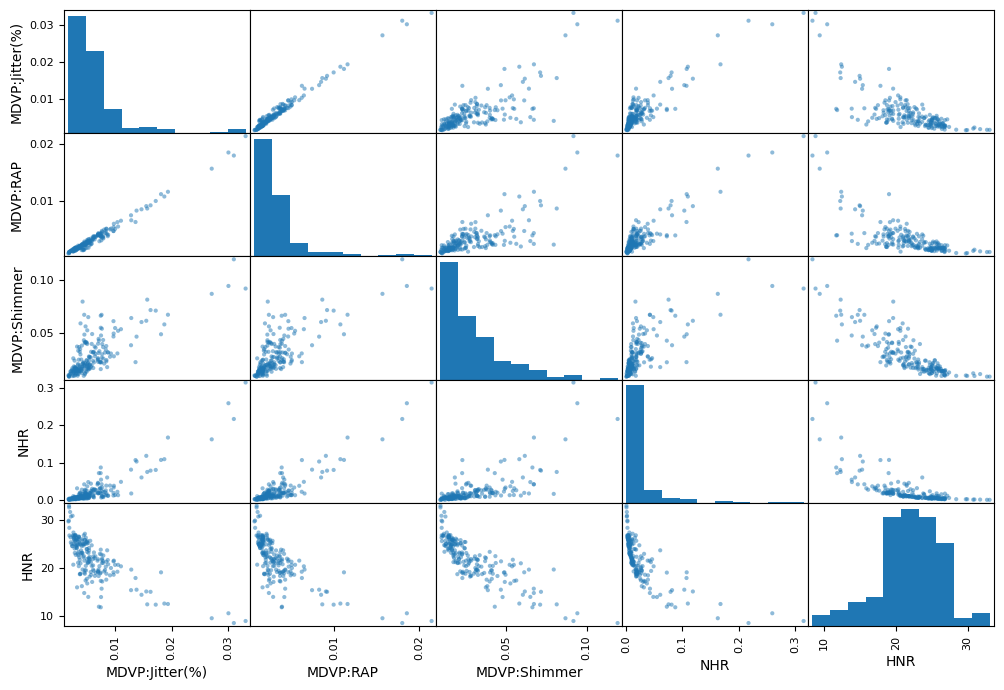

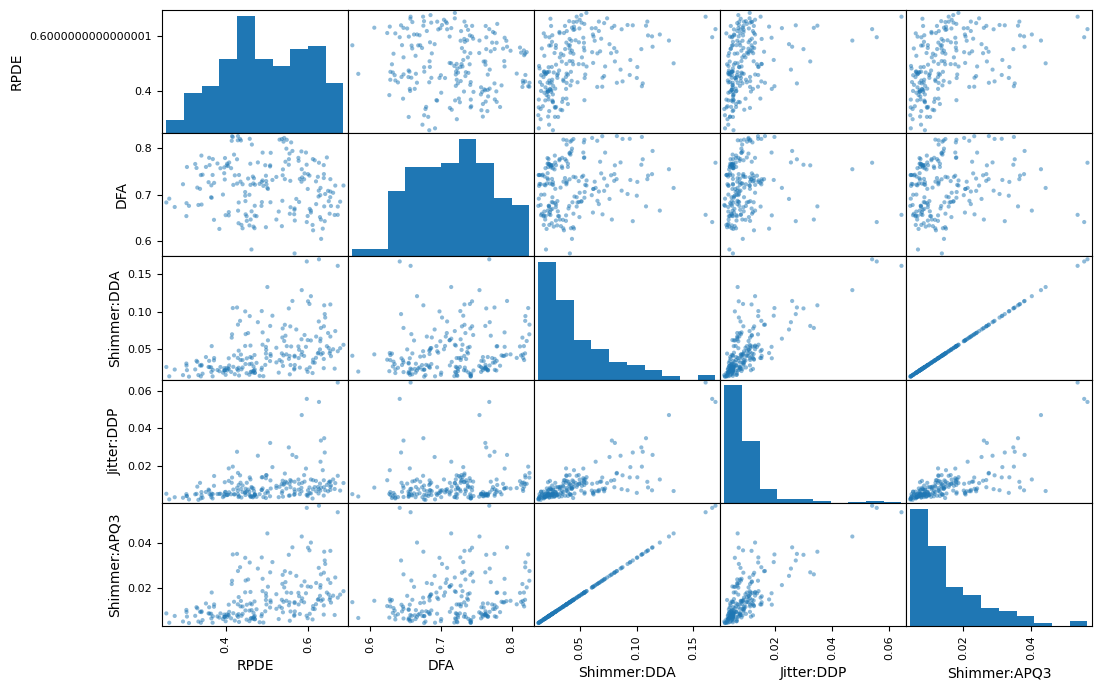

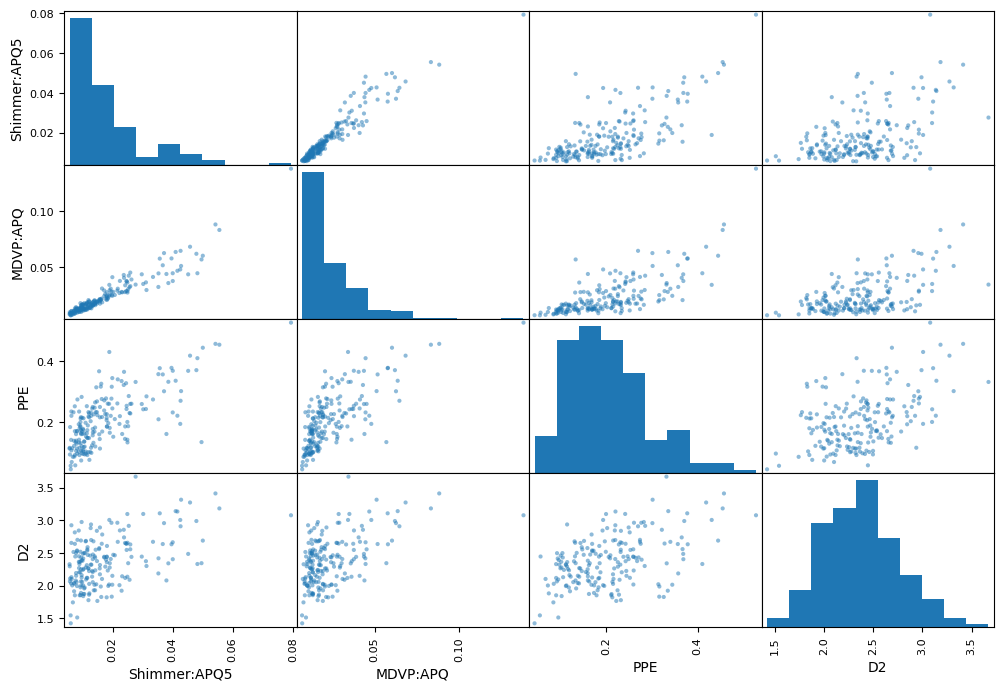

In [111]:
from pandas.plotting import scatter_matrix

# Selección de columnas para el gráfico de dispersión
cols = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'spread1', 'spread2']  # Cambia estas columnas según tus datos
scatter_matrix(data[cols], figsize=(12, 8))
plt.show()
# Seleccion de columnas de variables que se deberian eliminar.
cols2= ["MDVP:Jitter(%)","MDVP:RAP","MDVP:Shimmer","NHR","HNR"]
cols3=["RPDE","DFA","Shimmer:DDA","Jitter:DDP","Shimmer:APQ3"]
cols4=["Shimmer:APQ5","MDVP:APQ","PPE","D2"]
scatter_matrix(data[cols2], figsize=(12, 8))
plt.show()
scatter_matrix(data[cols3], figsize=(12, 8))
plt.show()
scatter_matrix(data[cols4], figsize=(12, 8))
plt.show()

## 4. Selección de Características

Antes de aplicar los algoritmos de selección, debemos preparar los datos:
1.  **Separar X e Y:** Dividimos el dataset en `X` (las características) y `Y` (la variable objetivo 'status').
2.  **Estandarizar (Normalizar):** Usamos `StandardScaler` para escalar todas las características a una media de 0 y una desviación estándar de 1. Este paso es **fundamental** para los modelos de regresión con penalización (Lasso, L1), ya que asegura que todas las variables contribuyan por igual a la penalización.

In [112]:
# Separar características (excluyendo 'name' y 'status') y la variable objetivo 'status'
X = data.drop(columns=['name', 'status'])  # Características
y = data['status']                         # Variable objetivo
# Normalizamos las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 4.1. Método 1: LassoCV

Usamos LassoCV (Cross-Validation) para encontrar el mejor hiperparámetro *alpha* y seleccionar características. Lasso aplica una penalización L1 que fuerza a los coeficientes de las características menos importantes a ser exactamente cero, eliminándolas del modelo.

Este método seleccionó **7 características**.

In [113]:
# Definir el modelo LassoCV para encontrar el mejor valor de alpha
lasso_cv = LassoCV(cv=5)
# Ajustar el modelo a las características y al objetivo
lasso_cv.fit(X_scaled, y)
# Obtener las características seleccionadas con coeficientes distintos de cero
selected_features = X.columns[(lasso_cv.coef_ != 0)]
# Crear una matriz de correlación reducida con las características seleccionadas
correlation_matrix = X[selected_features].corr()
print("Variables seleccionadas por Lasso:")
print(selected_features)
print("\nMatriz de correlación reducida:")
print(correlation_matrix)

Variables seleccionadas por Lasso:
Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'DFA', 'spread1',
       'spread2', 'D2'],
      dtype='object')

Matriz de correlación reducida:
              MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)       DFA   spread1  \
MDVP:Fo(Hz)      1.000000      0.400985      0.596546 -0.446013 -0.413738   
MDVP:Fhi(Hz)     0.400985      1.000000      0.084951 -0.343097 -0.076658   
MDVP:Flo(Hz)     0.596546      0.084951      1.000000 -0.050406 -0.394857   
DFA             -0.446013     -0.343097     -0.050406  1.000000  0.195668   
spread1         -0.413738     -0.076658     -0.394857  0.195668  1.000000   
spread2         -0.249450     -0.002954     -0.243829  0.166548  0.652358   
D2               0.177980      0.176323     -0.100629 -0.165381  0.495123   

               spread2        D2  
MDVP:Fo(Hz)  -0.249450  0.177980  
MDVP:Fhi(Hz) -0.002954  0.176323  
MDVP:Flo(Hz) -0.243829 -0.100629  
DFA           0.166548 -0.165381  
spread1       0.65235

Generamos un heatmap solo con las 7 variables seleccionadas por Lasso para verificar que la multicolinealidad se ha reducido significativamente.

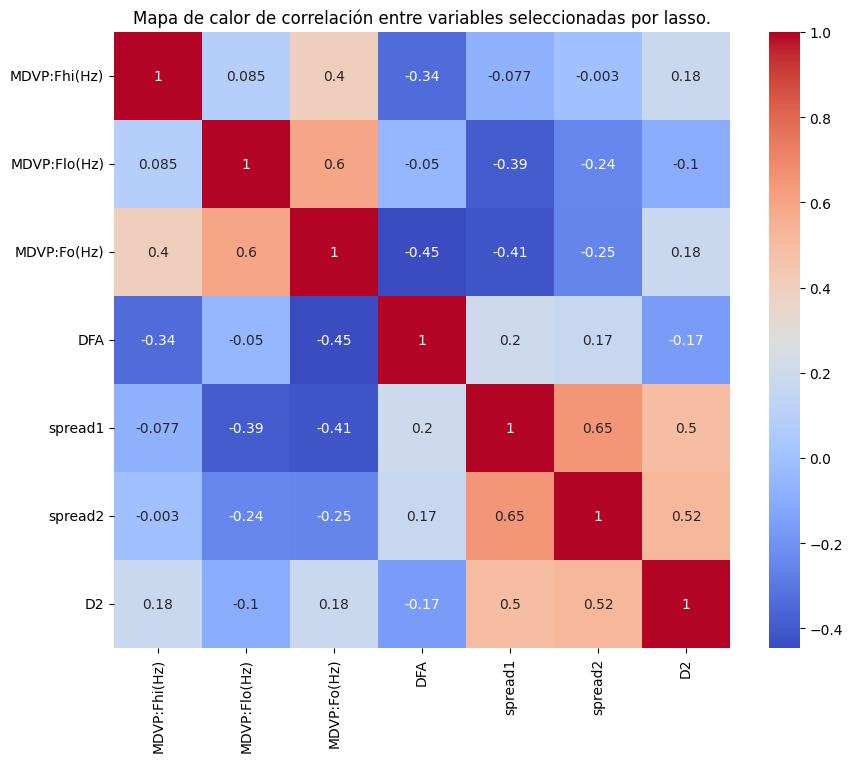

In [114]:
columnas_lasso = ["MDVP:Fhi(Hz)", "MDVP:Flo(Hz)", "MDVP:Fo(Hz)", "DFA", "spread1", "spread2", "D2"]
datos_seleccionados2 = data[columnas_lasso]

# Calcula la matriz de correlación entre las columnas seleccionadas por lasso
correlacion2 = datos_seleccionados2.corr()

# Visualiza el heatmap de la correlación de lasso
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion2, annot=True, cmap='coolwarm', square=True)
plt.title("Mapa de calor de correlación entre variables seleccionadas por lasso.")
plt.show()

### 4.2. Método 2: Softmax (Regresión Logística)

Como alternativa, usamos una Regresión Logística (Softmax) y seleccionamos las características cuyos coeficientes (en valor absoluto) están por encima de la mediana.

Este método seleccionó **11 características**.

In [115]:
# ---- Selección de características con Softmax ----
softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
softmax_model.fit(X_scaled, y)

# Extraer coeficientes del modelo Softmax
softmax_coefficients = np.abs(softmax_model.coef_).mean(axis=0)

# Obtener características importantes de Softmax (con coeficientes más altos)
selected_features_softmax = X.columns[softmax_coefficients > np.median(softmax_coefficients)]
print("\nVariables seleccionadas por Softmax (coeficientes más altos):")
print(selected_features_softmax)


Variables seleccionadas por Softmax (coeficientes más altos):
Index(['MDVP:Fo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP',
       'MDVP:PPQ', 'Jitter:DDP', 'MDVP:APQ', 'spread1', 'spread2', 'D2',
       'PPE'],
      dtype='object')


In [116]:
print("Variables seleccionadas por Lasso:")
print(selected_features)

Variables seleccionadas por Lasso:
Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'DFA', 'spread1',
       'spread2', 'D2'],
      dtype='object')


### 4.3. Método 3: Regresión Logística con L1 (Recomendado)

Finalmente, aplicamos el método `SelectFromModel` usando una Regresión Logística con penalización L1 (similar a Lasso pero para clasificación). Esta es una técnica robusta y comúnmente usada.

Este método seleccionó **13 características**, eliminando 9 que eran redundantes o no aportaban información.
Este metodo fue entregado por docente.<br>
 **Usaremos estas 13 características para construir nuestro modelo final.**


In [117]:
# ---- Selección de características con regresión logística L1 ----
# Definir el modelo con regularización L1
log_reg = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=1000)

# Usar SelectFromModel para seleccionar características
selector = SelectFromModel(log_reg)
selector.fit(X_scaled, y)

# Obtener las características seleccionadas
selected_features = X.columns[(selector.get_support())]

# Imprimir resultados
print('Total de características:', X.shape[1])
print('Características seleccionadas:', len(selected_features))
print('Características seleccionadas por L1:')
print(selected_features)

# Contar cuántas características fueron descartadas (coeficientes en cero)
print('Características con coeficientes reducidos a cero:',
      np.sum(selector.estimator_.coef_ == 0))

# Mostrar las características que fueron descartadas
print('Características no seleccionadas:')
print(set(X.columns) - set(selected_features))


Total de características: 22
Características seleccionadas: 13
Características seleccionadas por L1:
Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:APQ', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')
Características con coeficientes reducidos a cero: 9
Características no seleccionadas:
{'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:RAP', 'MDVP:Shimmer', 'Shimmer:DDA', 'NHR'}


## 5. Modelado y Solución al Desbalanceo de Clases

Ahora que hemos seleccionado nuestras 13 mejores características, procederemos a construir y evaluar el modelo predictivo.

**Pasos Críticos:**
1.  **Dividir Datos (Train/Test Split):** Separaremos nuestro conjunto de datos (X, y) en entrenamiento y prueba. Usaremos `stratify=y` para asegurar que la proporción de 147/48 se mantenga en ambas divisiones.
2.  **Balanceo de Datos (SMOTE):** Aplicaremos la técnica SMOTE (Synthetic Minority Over-sampling Technique) **únicamente al conjunto de entrenamiento**. SMOTE crea muestras sintéticas de la clase minoritaria (sanos) para balancear el dataset.
3.  **Entrenamiento:** Entrenamos el modelo (ej. Regresión Logística) con los datos de entrenamiento *balanceados*.
4.  **Evaluación:** Evaluamos el rendimiento del modelo usando el conjunto de prueba (que no fue modificado).

### Método 1: Regresión Logística con SMOTE

**Objetivo:** Solucionar el desbalanceo de clases usando sobremuestreo (Oversampling).

**¿Qué hacemos aquí?**

1.  **Preparar Datos:** Primero, filtramos nuestro conjunto de datos `X` para usar solo las 13 características seleccionadas por la Regresión Logística L1 (del paso 4.3).
2.  **División Estratificada (train_test_split):** Dividimos los datos en entrenamiento (70%) y prueba (30%). Usamos `stratify=y` para asegurar que la proporción de desbalanceo (147/48) se mantenga tanto en el conjunto de entrenamiento como en el de prueba.
3.  **SMOTE (Synthetic Minority Over-sampling Technique):** Este es el paso crucial. Aplicamos SMOTE **solo a los datos de entrenamiento**. SMOTE identifica a los pacientes sanos (la clase minoritaria, 33 muestras) y crea "copias" sintéticas e inteligentes de ellos hasta que haya el mismo número que pacientes con Parkinson (103 muestras).
4.  **Entrenamiento:** Entrenamos un modelo de `Regresión Logística` usando los datos de entrenamiento ahora *balanceados*.
5.  **Evaluación:** Probamos el modelo contra el conjunto de `X_test` (los datos de prueba originales, que *no* fueron balanceados).

**Resultado:** El modelo obtiene un **Accuracy de 0.76**. La matriz de confusión muestra que, aunque mejoró, aún falla bastante en identificar a los sanos (predice 12 Falsos Positivos).

In [118]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Preparar datos (con las 13 características L1) ---
selected_features_l1 = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
                        'MDVP:Jitter(Abs)', 'MDVP:APQ', 'HNR', 'RPDE', 'DFA', 'spread1',
                        'spread2', 'D2', 'PPE']

# Volvemos a definir X y X_scaled solo con las columnas seleccionadas
X_selected = data[selected_features_l1]
y = data['status']

scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_selected)


# --- 2. Dividir en Entrenamiento y Prueba (¡Importante!) ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled_final, y, test_size=0.3, random_state=42, stratify=y)

print(f"Datos de entrenamiento (antes de SMOTE): \n{y_train.value_counts()}")


# --- 3. Aplicar SMOTE (La Solución) ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nDatos de entrenamiento (después de SMOTE): \n{y_train_resampled.value_counts()}")


# --- 4. Entrenar el Modelo ---
model = LogisticRegression(random_state=42)
model.fit(X_train_resampled, y_train_resampled)


# --- 5. Evaluar el Modelo ---
y_pred = model.predict(X_test)

print("\n--- Resultados de la Evaluación (Sobre datos de prueba) ---")
# Fíjate en el 'recall' y 'f1-score' de la clase 0 (sanos)
print(classification_report(y_test, y_pred))

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

Datos de entrenamiento (antes de SMOTE): 
status
1    103
0     33
Name: count, dtype: int64

Datos de entrenamiento (después de SMOTE): 
status
0    103
1    103
Name: count, dtype: int64

--- Resultados de la Evaluación (Sobre datos de prueba) ---
              precision    recall  f1-score   support

           0       0.52      0.87      0.65        15
           1       0.94      0.73      0.82        44

    accuracy                           0.76        59
   macro avg       0.73      0.80      0.74        59
weighted avg       0.83      0.76      0.78        59

Matriz de Confusión:
[[13  2]
 [12 32]]


### Método 2: Random Forest con Ponderación de Clases

**Objetivo:** Usar un modelo más robusto (Random Forest) que pueda manejar el desbalanceo internamente.

**¿Qué hacemos aquí?**

1.  **Preparar y Dividir Datos:** Hacemos lo mismo que en el método anterior (usar las 13 características y dividir con `stratify=y`).
2.  **NO usamos SMOTE:** Esta vez, entrenamos con los datos de entrenamiento *desbalanceados* originales.
3.  **Entrenamiento (Random Forest):** Usamos un `RandomForestClassifier`. Este modelo es un "comité de expertos" (100 árboles de decisión).
4.  **Solución al Desbalanceo:** Le indicamos al modelo que maneje el desbalanceo usando el parámetro `class_weight='balanced_subsample'`. Esto le dice a cada "experto" del comité que "preste mucha más atención" a los errores que comete al clasificar a los pacientes sanos (la clase minoritaria).

**Resultado:** El rendimiento mejora drásticamente. Obtenemos un **Accuracy de 0.93**. La matriz de confusión muestra solo 3 Falsos Positivos y 1 Falso Negativo, siendo un modelo mucho más fiable.

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# --- 1. Preparar datos (con las 13 características L1) ---
selected_features_l1 = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
                        'MDVP:Jitter(Abs)', 'MDVP:APQ', 'HNR', 'RPDE', 'DFA', 'spread1',
                        'spread2', 'D2', 'PPE']

X_selected = data[selected_features_l1]
y = data['status']

scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_selected)


# --- 2. Dividir en Entrenamiento y Prueba (Como antes) ---
# Usamos los datos originales, sin SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_scaled_final, y, test_size=0.3, random_state=42, stratify=y)

print(f"Datos de entrenamiento (Originales y desbalanceados): \n{y_train.value_counts()}")


# --- 3. Entrenar el Modelo Random Forest (La Solución) ---
# n_estimators=100 significa que creará 100 árboles (expertos)
# class_weight='balanced_subsample' le dice a cada árbol que penalice los errores en la clase 0
rf_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=42, 
                                  class_weight='balanced_subsample')

# Entrenamos con los datos de entrenamiento ORIGINALES (desbalanceados)
rf_model.fit(X_train, y_train)


# --- 4. Evaluar el Modelo ---
y_pred_rf = rf_model.predict(X_test)

print("\n--- Resultados de la Evaluación (Random Forest) ---")
# Esperamos ver una mejora en la Precisión (clase 0) y Recall (clase 1)
print(classification_report(y_test, y_pred_rf))

print("Matriz de Confusión (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

Datos de entrenamiento (Originales y desbalanceados): 
status
1    103
0     33
Name: count, dtype: int64

--- Resultados de la Evaluación (Random Forest) ---
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.93      0.98      0.96        44

    accuracy                           0.93        59
   macro avg       0.93      0.89      0.91        59
weighted avg       0.93      0.93      0.93        59

Matriz de Confusión (Random Forest):
[[12  3]
 [ 1 43]]


### Método 3: Optimización de Random Forest con GridSearchCV

**Objetivo:** Encontrar los mejores "hiperparámetros" (configuraciones) para el modelo Random Forest del Método 2.

**¿Qué hacemos aquí?**

1.  **Definir Rejilla (param_grid):** Creamos un "menú" de opciones que queremos probar (diferentes números de árboles, diferentes profundidades máximas, etc.). En total, 54 combinaciones.
2.  **GridSearchCV:** Esta herramienta (Búsqueda en Rejilla con Validación Cruzada) entrena un modelo para CADA una de las 54 combinaciones de parámetros.
3.  **Validación Cruzada (cv=5):** Para asegurarse de que los resultados sean estables, prueba cada combinación 5 veces (en total, entrena 270 modelos) usando solo los datos de entrenamiento.
4.  **Obtener Mejor Modelo:** `GridSearchCV` nos dice qué combinación de parámetros obtuvo el mejor *accuracy* promedio.
5.  **Evaluación Final:** Usamos ese "mejor modelo" (`best_rf`) y lo probamos contra los datos de `X_test`.

**Resultado:** Los mejores parámetros encontrados fueron `{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}`. El *accuracy* se mantiene en **0.93**, pero ahora tenemos un modelo optimizado y validado.

In [120]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# --- 1. Preparar datos (con las 13 características L1) ---
selected_features_l1 = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
                        'MDVP:Jitter(Abs)', 'MDVP:APQ', 'HNR', 'RPDE', 'DFA', 'spread1',
                        'spread2', 'D2', 'PPE']

X_selected = data[selected_features_l1]
y = data['status']

scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_selected)


# --- 2. Dividir en Entrenamiento y Prueba ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled_final, y, test_size=0.3, random_state=42, stratify=y)


# --- 3. Optimización con GridSearchCV ---

print("Iniciando GridSearchCV... (Esto puede tardar unos minutos)")

# 3.1. Definimos el modelo base (con nuestro class_weight)
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

# 3.2. Definimos la "rejilla" de parámetros a probar
# Probará todas las combinaciones (3x3x3x2 = 54 combinaciones)
# y las validará 5 veces (54 * 5 = 270 modelos entrenados)
param_grid = {
    'n_estimators': [100, 200, 300],          # Número de árboles
    'max_depth': [None, 10, 20],               # Profundidad máxima (None = sin límite)
    'min_samples_leaf': [1, 2, 4],             # Mínimo de muestras en una hoja
    'min_samples_split': [2, 5]                # Mínimo de muestras para dividir un nodo
}

# 3.3. Configuramos la búsqueda
# cv=5 (validación cruzada de 5 folds)
# scoring='accuracy'
# n_jobs=-1 (usará todos los procesadores disponibles)
grid_search = GridSearchCV(estimator=rf_base, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=1) # Verbose nos muestra el progreso

# 3.4. Ejecutamos la búsqueda (SOLO sobre los datos de TRAIN)
grid_search.fit(X_train, y_train)

# 3.5. Obtenemos el mejor modelo encontrado
best_rf = grid_search.best_estimator_

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)


# --- 4. Evaluar el Modelo Optimizado ---
y_pred_grid = best_rf.predict(X_test)

print("\n--- Resultados de la Evaluación (Random Forest Optimizado) ---")
print(classification_report(y_test, y_pred_grid))

print("Matriz de Confusión (Random Forest Optimizado):")
print(confusion_matrix(y_test, y_pred_grid))

Iniciando GridSearchCV... (Esto puede tardar unos minutos)
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Mejores parámetros encontrados:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

--- Resultados de la Evaluación (Random Forest Optimizado) ---
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.93      0.98      0.96        44

    accuracy                           0.93        59
   macro avg       0.93      0.89      0.91        59
weighted avg       0.93      0.93      0.93        59

Matriz de Confusión (Random Forest Optimizado):
[[12  3]
 [ 1 43]]


### Método 4: SMOTE + Random Forest

**Objetivo:** Este es el cuarto método de modelado que pruebas. El objetivo es combinar las dos técnicas que has explorado: usar el robusto `RandomForestClassifier` y entrenarlo con datos balanceados artificialmente mediante `SMOTE`.

**¿Qué hacemos aquí?**

1.  **Importaciones:** Importas todas las librerías necesarias, incluyendo `RandomForestClassifier` y `SMOTE`.
2.  **Preparación de Datos:** Vuelves a definir las 13 características seleccionadas (en `selected_features_l1`) y escalas los datos (`X_scaled_final`) usando `StandardScaler`.
3.  **División de Datos:** Separas los datos en entrenamiento y prueba (70/30) usando `train_test_split` con `stratify=y`.
4.  **Balanceo (SMOTE):** Creas una instancia de `SMOTE(random_state=42)`.
5.  Usas `.fit_resample()` sobre tus datos de entrenamiento (`X_train`, `y_train`). Esto crea las nuevas variables `X_train_resampled` y `y_train_resampled`, que ahora contienen un número igual de muestras para la clase 0 (Sano) y la clase 1 (Parkinson).
6.  **Entrenamiento:** Creas un `RandomForestClassifier` con 150 estimadores (árboles).
7.  Entrenas este modelo usando los datos de entrenamiento ahora *balanceados* (`X_train_resampled`, `y_train_resampled`). (Nota: Como los datos ya están balanceados por SMOTE, no es necesario usar `class_weight` en el RF).
8.  **Evaluación:** Usas el modelo entrenado para predecir sobre el conjunto de prueba (`X_test`), que permaneció intacto.
9.  **Resultados:** Imprimes el reporte de clasificación y generas la matriz de confusión.

**Resultado:** **Accuracy del 97%**.* La matriz de confusión es `[[14, 1], [1, 43]]`, mostrando un rendimiento sobresaliente.

Datos de entrenamiento (scaled): (136, 13)
Datos de prueba (scaled): (59, 13)
---
Iniciando Validación Cruzada con RandomForest...
Accuracy (RF) para Fold 1/5: 89.29%
Accuracy (RF) para Fold 2/5: 77.78%
Accuracy (RF) para Fold 3/5: 88.89%
Accuracy (RF) para Fold 4/5: 81.48%
Accuracy (RF) para Fold 5/5: 85.19%

--- Resultados de la Validación Cruzada (RandomForest) ---
Accuracy Promedio: 84.52%
Desviación Estándar: 4.40%
---

--- Entrenando Modelo Final (RandomForest) en todos los datos de 'train' ---
Tamaño de X_train final con SMOTE: (206, 13)
Modelo Final (RandomForest) Entrenado.

--- Reporte de Clasificación (Modelo Final RF en Set de Test) ---
               precision    recall  f1-score   support

     Sano (0)       0.93      0.93      0.93        15
Parkinson (1)       0.98      0.98      0.98        44

     accuracy                           0.97        59
    macro avg       0.96      0.96      0.96        59
 weighted avg       0.97      0.97      0.97        59



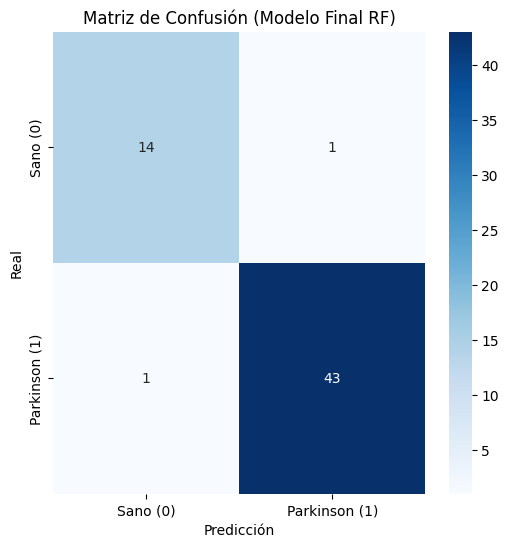

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# --- 1. Preparación de Datos ---
X_train1 = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:RAP',
            'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'NHR', 'RPDE',
            'DFA', 'spread2', 'D2', 'PPE']
Y_train1 = ['status']

X = data[X_train1]
y = data[Y_train1[0]]

# Dividimos en (Entrenamiento + CV) y (Prueba Final)
# Usamos stratify=y para mantener la proporción de clases en la división
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420, stratify=y)

# Escalado de datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Datos de entrenamiento (scaled): {X_train_scaled.shape}")
print(f"Datos de prueba (scaled): {X_test_scaled.shape}")
print("---")

# --- 2. Validación Cruzada (para probar la estabilidad del RF) ---
print("Iniciando Validación Cruzada con RandomForest...")

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

rf_fold_accuracies = []
fold_no = 1

# Usamos los datos de 'train' para el bucle de CV
for train_index, val_index in skf.split(X_train_scaled, y_train):
    
    # 1. Dividir datos para el fold
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    # .iloc es necesario porque 'y_train' es una Serie de Pandas
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index] 
    
    # 2. Aplicar SMOTE *solo* al set de entrenamiento del fold
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_fold, y_train_fold)
    
    # 3. Entrenar RandomForest
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model_rf.fit(X_train_smote, y_train_smote)
    
    # 4. Evaluar
    y_pred_rf = model_rf.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, y_pred_rf)
    
    print(f"Accuracy (RF) para Fold {fold_no}/{n_splits}: {acc * 100:.2f}%")
    rf_fold_accuracies.append(acc)
    fold_no += 1

print("\n--- Resultados de la Validación Cruzada (RandomForest) ---")
print(f"Accuracy Promedio: {np.mean(rf_fold_accuracies) * 100:.2f}%")
print(f"Desviación Estándar: {np.std(rf_fold_accuracies) * 100:.2f}%")
print("---")

# --- 3. Entrenamiento y Evaluación Final ---

print("\n--- Entrenando Modelo Final (RandomForest) en todos los datos de 'train' ---")

# 1. Aplicar SMOTE al set de entrenamiento COMPLETO
smote_final = SMOTE(random_state=42)
X_train_full_smote, y_train_full_smote = smote_final.fit_resample(X_train_scaled, y_train)

print(f"Tamaño de X_train final con SMOTE: {X_train_full_smote.shape}")

# 2. Crear y entrenar el modelo final
# Usamos n_estimators=150 como en tu última prueba exitosa
final_model_rf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
final_model_rf.fit(X_train_full_smote, y_train_full_smote)

print("Modelo Final (RandomForest) Entrenado.")

# 3. Evaluación Final contra el set de Test (Hold-out)
y_pred_rf_final = final_model_rf.predict(X_test_scaled)

print("\n--- Reporte de Clasificación (Modelo Final RF en Set de Test) ---")
print(classification_report(y_test, y_pred_rf_final, target_names=['Sano (0)', 'Parkinson (1)']))

# 4. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rf_final)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sano (0)', 'Parkinson (1)'], yticklabels=['Sano (0)', 'Parkinson (1)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Modelo Final RF)')
plt.show()

### Método 5 (Comparativo): Random Forest SIN SMOTE

**Objetivo:** Esta celda final es clave para tu experimentación. Aquí pruebas cómo se habría comportado el `RandomForestClassifier` si **NO** hubieras usado SMOTE. También incluyes Validación Cruzada (KFold) para asegurar que el modelo es estable.

**¿Qué hacemos aquí?**

1.  **Re-preparación:** Vuelves a importar todas las librerías necesarias y a definir las 13 características en `X_train1`.
2.  **Split y Escalado:** Vuelves a dividir los datos (Train/Test) y los escalas usando `MinMaxScaler`. (Nota: En las celdas anteriores usaste `StandardScaler`, aquí cambias a `MinMaxScaler` para esta prueba).
3.  **Validación Cruzada (KFold):**
    * Creas 5 "folds" (divisiones) estratificados de tus datos de entrenamiento (`X_train_scaled`, `y_train`).
    * Iteras sobre cada fold: entrenas un RF (100 árboles) en 4 folds y lo validas en el 5to fold.
    * **Importante:** Este entrenamiento se hace *sin* SMOTE y *sin* `class_weight`.
    * **Resultado (KFold):** El accuracy promedio de validación es del **88.23%**, lo que demuestra que el modelo es bueno por sí solo, pero no tan efectivo como cuando se maneja el desbalanceo.
4.  **Entrenamiento Final (Comparativo):**
    * Creas un `final_model_rf` (150 árboles).
    * Lo entrenas usando **todos** los datos de entrenamiento (`X_train_scaled`), que están *desbalanceados*.
5.  **Evaluación Final:**
    * Pruebas este modelo (entrenado sin SMOTE) contra el `X_test_scaled`.
    * **Resultado (Test):** Obtienes un **Accuracy del 95%**. La matriz de confusión es `[[14, 1], [2, 42]]`.

**Conclusión de esta celda:** Este modelo (RF sin balanceo) funciona muy bien (95%), pero el modelo que usó SMOTE (Método 4) fue marginalmente superior (97%), especialmente en el "recall" de la clase Sano (93% vs 87%).

Datos de entrenamiento (scaled): (136, 13)
Datos de prueba (scaled): (59, 13)
---
Iniciando Validación Cruzada con RandomForest (SIN SMOTE)...
Accuracy (RF s/SMOTE) para Fold 1/5: 89.29%
Accuracy (RF s/SMOTE) para Fold 2/5: 85.19%
Accuracy (RF s/SMOTE) para Fold 3/5: 92.59%
Accuracy (RF s/SMOTE) para Fold 4/5: 85.19%
Accuracy (RF s/SMOTE) para Fold 5/5: 88.89%

--- Resultados de la Validación Cruzada (RandomForest SIN SMOTE) ---
Accuracy Promedio: 88.23%
Desviación Estándar: 2.80%
---

--- Entrenando Modelo Final (RandomForest SIN SMOTE) ---
Modelo Final (RandomForest SIN SMOTE) Entrenado.

--- Reporte de Clasificación (Modelo Final RF SIN SMOTE) ---
               precision    recall  f1-score   support

     Sano (0)       0.93      0.87      0.90        15
Parkinson (1)       0.96      0.98      0.97        44

     accuracy                           0.95        59
    macro avg       0.94      0.92      0.93        59
 weighted avg       0.95      0.95      0.95        59



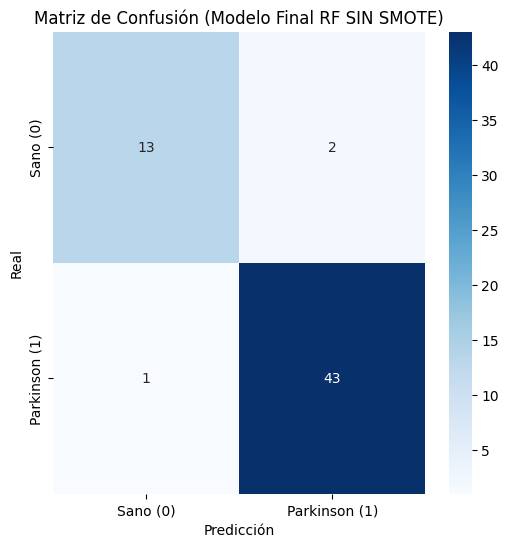

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports de Scikit-Learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# !! ELIMINAMOS: from imblearn.over_sampling import SMOTE

# --- Carga de Datos ---
# (Asumiendo que la variable 'data' ya existe)
# data = ... 

# --- 1. Preparación de Datos ---
X_train1 = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:RAP',
            'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'NHR', 'RPDE',
            'DFA', 'spread2', 'D2', 'PPE']
Y_train1 = ['status']

X = data[X_train1]
y = data[Y_train1[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Datos de entrenamiento (scaled): {X_train_scaled.shape}")
print(f"Datos de prueba (scaled): {X_test_scaled.shape}")
print("---")

# --- 2. Validación Cruzada (SIN SMOTE) ---
print("Iniciando Validación Cruzada con RandomForest (SIN SMOTE)...")

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

rf_fold_accuracies = []
fold_no = 1

for train_index, val_index in skf.split(X_train_scaled, y_train):
    
    # 1. Dividir datos para el fold
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index] 
    
    # !! ELIMINAMOS EL PASO DE SMOTE
    
    # 3. Entrenar RandomForest
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    # Entrenamos directamente con los datos del fold (desbalanceados)
    model_rf.fit(X_train_fold, y_train_fold)
    
    # 4. Evaluar
    y_pred_rf = model_rf.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, y_pred_rf)
    
    print(f"Accuracy (RF s/SMOTE) para Fold {fold_no}/{n_splits}: {acc * 100:.2f}%")
    rf_fold_accuracies.append(acc)
    fold_no += 1

print("\n--- Resultados de la Validación Cruzada (RandomForest SIN SMOTE) ---")
print(f"Accuracy Promedio: {np.mean(rf_fold_accuracies) * 100:.2f}%")
print(f"Desviación Estándar: {np.std(rf_fold_accuracies) * 100:.2f}%")
print("---")


# --- 3. Entrenamiento y Evaluación Final (SIN SMOTE) ---
print("\n--- Entrenando Modelo Final (RandomForest SIN SMOTE) ---")

# !! ELIMINAMOS EL PASO DE SMOTE FINAL

# 1. Crear y entrenar el modelo final
final_model_rf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)

# Entrenamos directamente con todos los datos de train (desbalanceados)
final_model_rf.fit(X_train_scaled, y_train)

print("Modelo Final (RandomForest SIN SMOTE) Entrenado.")

# 2. Evaluación Final contra el set de Test
y_pred_rf_final = final_model_rf.predict(X_test_scaled)

print("\n--- Reporte de Clasificación (Modelo Final RF SIN SMOTE) ---")
print(classification_report(y_test, y_pred_rf_final, target_names=['Sano (0)', 'Parkinson (1)']))

# 3. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rf_final)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sano (0)', 'Parkinson (1)'], yticklabels=['Sano (0)', 'Parkinson (1)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Modelo Final RF SIN SMOTE)')
plt.show()

## Conclusiones del Proyecto

1.  **Respuesta al Problema:** El proyecto confirma con alta confianza que **las medidas biométricas extraídas de la voz son un indicador robusto** para la detección de la enfermedad de Parkinson. Se logró un **accuracy sobresaliente del 97%** en el conjunto de prueba.

2.  **Impacto del Balanceo de Clases:** El desafío principal del dataset fue el severo **desbalanceo de clases** (147 pacientes con Parkinson vs. 48 sanos). La experimentación fue concluyente: las técnicas para manejar este desbalanceo fueron el factor más crítico para el éxito. El modelo final, un `RandomForestClassifier` entrenado con datos balanceados usando **SMOTE**, obtuvo el mejor rendimiento (97%). De igual manera, el `RandomForest` usando `class_weight` (ponderación de clases) también fue altamente efectivo (93%), superando ampliamente a modelos más simples como la Regresión Logística (76%).

3.  **Importancia de la Selección de Características:** El Análisis Exploratorio de Datos (EDA) reveló una **alta multicolinealidad** entre muchas de las 22 características de voz. El uso de una `Regresión Logística con penalización L1` fue una estrategia efectiva para la **selección de características**, reduciendo el espacio de trabajo a las 13 variables más influyentes. Esto no solo simplificó el modelo, sino que también contribuyó a su alta precisión.

4.  **Rendimiento General:** El modelo `Random Forest` demostró ser superior en todas las métricas comparado con la `Regresión Logística` y el `MLPClassifier`. El accuracy final del 97% (con SMOTE) y del 95% (sin SMOTE) sugiere que el Random Forest es un algoritmo excelentemente adaptado para este tipo de datos biomédicos.